# Billboard Year-End Top 100 
* Scraped the artists/songs from <a href="https://www.billboard.com/charts/year-end/2017/hot-100-songs">Billboard's year-end top 100</a>, which includes songs from 2006-2017.
* Scraped the lyrics from <a href="https://genius.com/">Genius</a> using their API. The text went through a cleansing routine at theis stage, and included removing Genius identifiers (the site labels aspects of the text), punctuation, numbers, and lower cased everything. Admittedly, some useful insights may be extracted from the cleansed information but this is not performed here.
* Let's look at some simple characteristics of the lyrics

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')

## Load the data
* Check for null cells and remove.

In [35]:
data = pd.read_csv('song_lyrics_v1.csv', header=None)
data.columns = ['year', 'top100', 'song','artist','lyrics']

In [36]:
def check_nulls(data,more=False):
    print('Any nulls? %s \nIf so, how many? %d' % 
          ("True" if data.isnull().any().any() else "False",
           data.isnull().sum().sum()))
    if more:
        missing =data.apply(lambda x: sum(x.isnull()), axis = 0)
        print(missing)

In [37]:
check_nulls(data,True)

Any nulls? True 
If so, how many? 4
year      0
top100    0
song      0
artist    0
lyrics    4
dtype: int64


* There are 4 lyric nulls due to the scraping procedure. Some artists / songs did not behave well with Genuis API
* Let's just remove these entries

In [38]:
null_columns = data.columns[data.isnull().any()]
print(data[data["lyrics"].isnull()][null_columns])
print(data[253:254])

    lyrics
253    NaN
549    NaN
775    NaN
917    NaN
     year  top100                     song              artist lyrics
253  2008      54  Crank That (Soulja Boy)  Soulja Boy Tell'em    NaN


In [39]:
# Simply remove these rows as they are useless with no lyrics
data = data.dropna(axis=0, how='any')
print(data.shape)

(1194, 5)


* I want to bin the top100 variable, and there is a lot of wiggle room here
* Started with 10 bins, but eventually went down to 4

In [40]:
def top100_cat(row):
    return int((row['top100']-1)/25) + 1

data['top100_cat'] = data.apply(lambda row: top100_cat(row), axis=1)

## Adding new features based on lyric information
* Need to tokenize
* Can easily calculate number of words, number of unique words, average word length, frequency behavior, etc.

In [41]:
words, uwords, mwords, fwords, ratio = [],[],[],[], []
avg_word_length=[]
for index, row in data.iterrows():
    output = str(row['lyrics'])
    tokens = [s.strip() for s in output.split() if s] 
    unique_words = {}
    words.append(len(tokens))
    avg=0
    for w in tokens:
        avg += len(w)
        if w in unique_words:
            unique_words[w] += 1
        else:
            unique_words[w] = 1
    avg /= len(tokens)
    avg_word_length.append(avg)
    max = -1
    maxk=""
    for k, v in unique_words.items():
        if v > max:
            max = v
            maxk = k
    uwords.append(len(unique_words))
    mwords.append(str(maxk))
    fwords.append(max)
    ratio.append(len(unique_words) / len(tokens))

In [42]:
# Add some new rows
data['number_words'] = words
data['unique_words'] = uwords
data['max_word'] = mwords
data['freq_word'] = fwords
data['ratio']  = ratio
data['avg_word_length'] = avg_word_length

In [43]:
data.head().T

,0,1,2,3,4
year,2006,2006,2006,2006,2006
top100,1,2,3,4,5
song,Bad Day,Temperature,Promiscuous,You're Beautiful,Hips Don't Lie
artist,Daniel Powter,Sean Paul,Nelly Furtado,James Blunt,Shakira
lyrics,where is the moment we needed the most you kic...,the gyal dem schillaci sean da paul so me give...,am i throwing you off nope didnt think so how ...,my life is brilliant my life is brilliant my l...,ladies up in here tonight no fighting no fight...
top100_cat,1,1,1,1,1
number_words,395,747,596,199,557
unique_words,118,220,216,85,183
max_word,you,you,you,na,you
freq_word,42,32,51,13,24


## Word cloud for the most frequently used words in all songs
* The highest frequency word for all songs is plotted (1 word per song)
* Obviously there may be some issues here, i.e. "words" like i, a, you, me, etc are common which get filtered via the introduction of the "stop words"

In [44]:
words = data['max_word'].values
comment_words = " "
for w in words:
    comment_words += w + " "

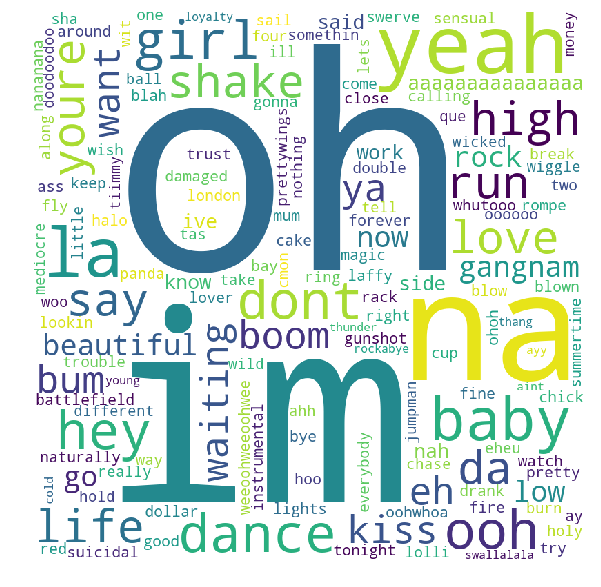

In [45]:
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords=stopwords,
                min_font_size = 10).generate(comment_words) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

## New feature plots

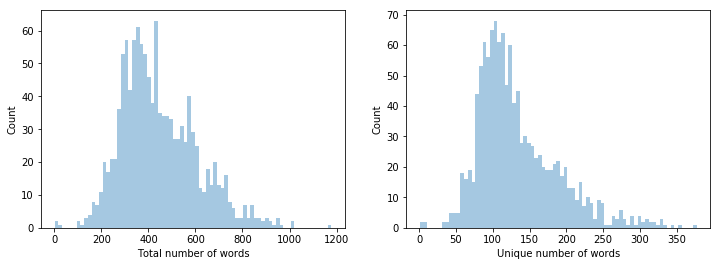

In [46]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
sns.distplot(data.number_words, kde=False, bins=75, ax=ax1)
ax1.set_xlabel("Total number of words")
ax1.set_ylabel("Count")

sns.distplot(data.unique_words, kde=False, bins=75, ax=ax2)
ax2.set_xlabel("Unique number of words")
ax2.set_ylabel("Count")
plt.show()

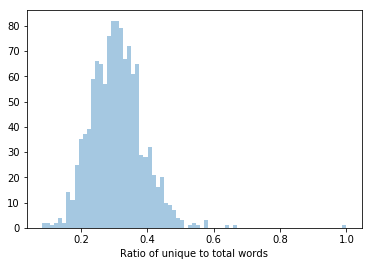

In [62]:
sns.distplot(data.unique_words/data.number_words, kde=False, bins=75)
plt.xlabel("Ratio of unique to total words")
plt.show()

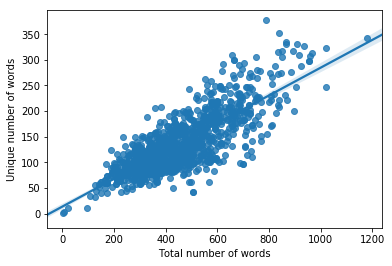

In [106]:
f = plt.figure()
ax1 = f.add_subplot(1,1,1)
p = sns.regplot(x=data.number_words, y=data.unique_words, ax=ax1 )
ax1.set_xlabel("Total number of words")
ax1.set_ylabel("Unique number of words")
plt.show()

In [110]:
def get_fit_pars(p):
    x=p.get_lines()[0].get_xdata()
    y=p.get_lines()[0].get_ydata()
    x2,x1 = x[-1], x[0]
    y2,y1 = y[-1], y[0]

    # Get slope
    m = (x2-x1)/(y2-y1)
    print('m = %1.3f' % m)
    
    dx = x[1] - x[0]
    y1,y2,x1,x2 = y[4], y[5], x[4], x[5]
    print("(%1.2f, %1.2f),(%1.2f, %1.2f), dx=%1.2f" % (x1,y1,x2,y2,dx) )
    dxleft = abs(x1)/dx
    dy = y2 - y1
    y0 = y1 + dy*dxleft
    #print(dxleft, dy, y0)
    print('b = %1.3f' % (y0))

In [111]:
# Get the line info
get_fit_pars(p)

m = 3.688
(-5.98, 11.95),(7.11, 15.50), dx=13.09
b = 13.570


## Let's plot the bin

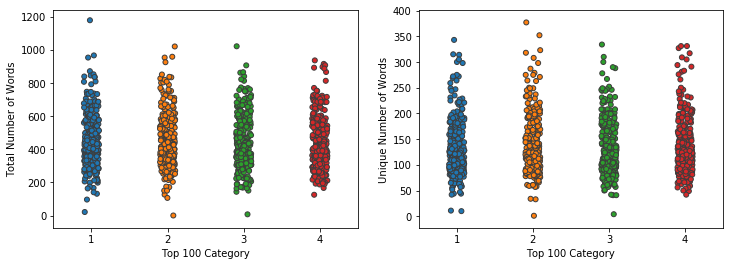

In [112]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
sns.stripplot(data["top100_cat"],data["number_words"], 
              jitter=True, linewidth=1, ax=ax1)
ax1.set_xlabel('Top 100 Category')
ax1.set_ylabel('Total Number of Words')

sns.stripplot(data["top100_cat"],data["unique_words"], 
              jitter=True, linewidth=1, ax=ax2)
ax2.set_xlabel('Top 100 Category')
ax2.set_ylabel('Unique Number of Words')
plt.show()

In [50]:
data[['top100_cat','number_words']].groupby(['top100_cat'], as_index=False).mean()

,top100_cat,number_words
0,1,455.979933
1,2,453.327759
2,3,437.093645
3,4,429.043771


In [51]:
data[['top100_cat','unique_words']].groupby(['top100_cat'], as_index=False).mean()

,top100_cat,unique_words
0,1,133.668896
1,2,135.053512
2,3,133.749164
3,4,133.181818


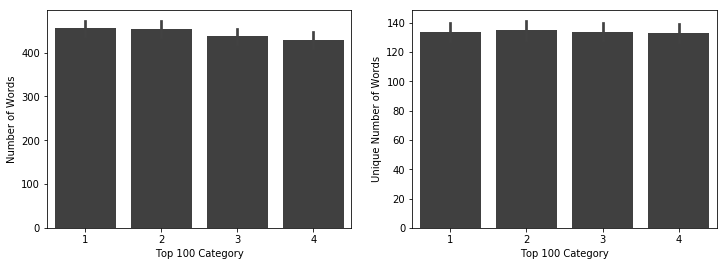

In [52]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
sns.barplot(data["top100_cat"], data["number_words"],
            alpha=0.75, color='black', ax=ax1)
ax1.set_xlabel('Top 100 Category')
ax1.set_ylabel('Number of Words')
sns.barplot(data["top100_cat"], data["unique_words"],
            alpha=0.75, color='black', ax=ax2)
ax2.set_xlabel('Top 100 Category')
ax2.set_ylabel('Unique Number of Words')
plt.show()

In [53]:
ratio_cat = data[['top100_cat','ratio']].groupby(['top100_cat'], as_index=False).mean()

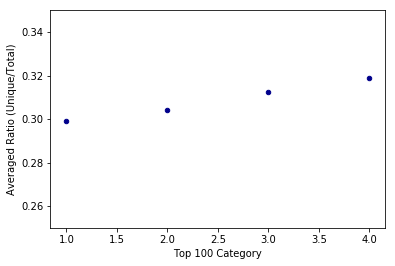

In [54]:
ax1 = ratio_cat.plot.scatter(x='top100_cat',y='ratio', c='DarkBlue')
ax1.set_xlabel('Top 100 Category')
ax1.set_ylabel('Averaged Ratio (Unique/Total)')
plt.ylim(0.25,0.35)
plt.show()

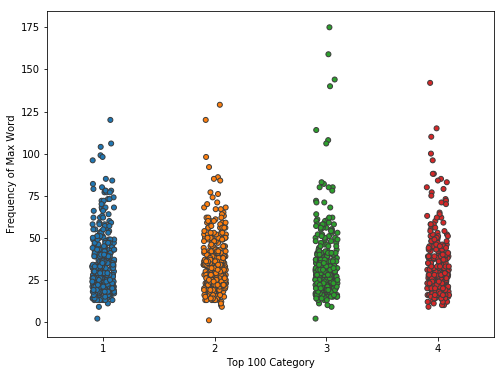

In [55]:
fig, ax1 = plt.subplots(figsize=(8,6))
sns.stripplot(data["top100_cat"],data["freq_word"], 
              jitter=True, linewidth=1, ax=ax1)
ax1.set_xlabel('Top 100 Category')
ax1.set_ylabel('Frequency of Max Word')
plt.show()

In [56]:
freq = data[['top100_cat','freq_word']].groupby(['top100_cat'], as_index=False).mean()

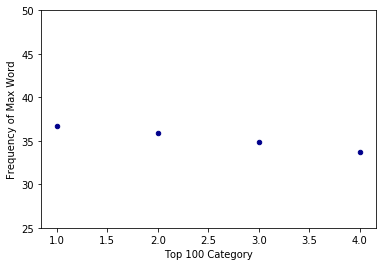

In [57]:
ax1 = freq.plot.scatter(x='top100_cat',y='freq_word', c='DarkBlue')
ax1.set_xlabel('Top 100 Category')
ax1.set_ylabel('Frequency of Max Word')
plt.ylim(25,50)
plt.show()

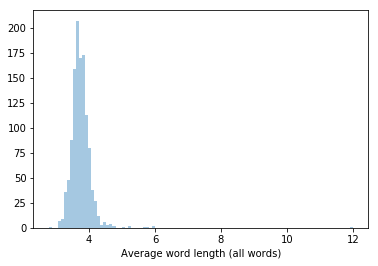

In [58]:
sns.distplot(data.avg_word_length, kde=False, bins=100)
plt.xlabel("Average word length (all words)")
plt.show()

In [59]:
length = data[['top100_cat','avg_word_length']].groupby(['top100_cat'], as_index=False).mean()

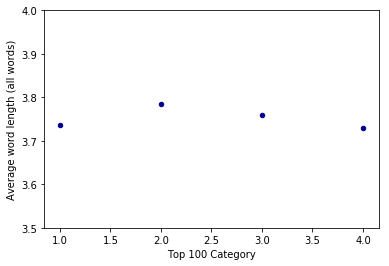

In [60]:
ax1 = length.plot.scatter(x='top100_cat',y='avg_word_length', c='DarkBlue')
ax1.set_xlabel('Top 100 Category')
ax1.set_ylabel("Average word length (all words)")
ax1.set_ylim(3.5,4)
plt.show()